In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_e_e_1_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(466039, 919)
(466039, 1)
validation
(80707, 919)
(80707, 1)
test
(46831, 919)
(46831, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1631233 (6.22 MB)


Trainable params: 1631233 (6.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/47 [..............................] - ETA: 1:05 - loss: 0.1989 - STD: 1.6434e-04 - MAE: 0.4318

 2/47 [>.............................] - ETA: 42s - loss: 0.0975 - STD: 4.4589e-04 - MAE: 0.3015 

 5/47 [==>...........................] - ETA: 10s - loss: 0.0480 - STD: 3.9488e-04 - MAE: 0.1859

 8/47 [====>.........................] - ETA: 6s - loss: 0.0430 - STD: 2.7063e-04 - MAE: 0.1732 

11/47 [======>.......................] - ETA: 4s - loss: 0.0415 - STD: 2.0107e-04 - MAE: 0.1694

14/47 [=======>......................] - ETA: 3s - loss: 0.0404 - STD: 1.6346e-04 - MAE: 0.1662

17/47 [=========>....................] - ETA: 2s - loss: 0.0388 - STD: 1.4235e-04 - MAE: 0.1616

20/47 [===========>..................] - ETA: 1s - loss: 0.0365 - STD: 1.3044e-04 - MAE: 0.1545

23/47 [=============>................] - ETA: 1s - loss: 0.0337 - STD: 1.2312e-04 - MAE: 0.1461

26/47 [===============>..............] - ETA: 1s - loss: 0.0313 - STD: 1.1753e-04 - MAE: 0.1398

28/47 [================>.............] - ETA: 1s - loss: 0.0302 - STD: 1.1388e-04 - MAE: 0.1375

30/47 [==================>...........] - ETA: 0s - loss: 0.0293 - STD: 1.1001e-04 - MAE: 0.1358

32/47 [===================>..........] - ETA: 0s - loss: 0.0284 - STD: 1.0576e-04 - MAE: 0.1338

34/47 [====================>.........] - ETA: 0s - loss: 0.0275 - STD: 1.0140e-04 - MAE: 0.1315

36/47 [=====================>........] - ETA: 0s - loss: 0.0267 - STD: 9.7111e-05 - MAE: 0.1291

38/47 [=======================>......] - ETA: 0s - loss: 0.0259 - STD: 9.3054e-05 - MAE: 0.1268

40/47 [========================>.....] - ETA: 0s - loss: 0.0253 - STD: 8.9307e-05 - MAE: 0.1247

42/47 [=========================>....] - ETA: 0s - loss: 0.0248 - STD: 8.5883e-05 - MAE: 0.1228

45/47 [===========================>..] - ETA: 0s - loss: 0.0240 - STD: 8.1342e-05 - MAE: 0.1202

47/47 [==============================] - 4s 60ms/step - loss: 0.0235 - STD: 7.8688e-05 - MAE: 0.1188 - val_loss: 0.0114 - val_STD: 1.3696e-05 - val_MAE: 0.0797


Epoch 2/10000


 1/47 [..............................] - ETA: 1s - loss: 0.0126 - STD: 1.9588e-05 - MAE: 0.0865

 3/47 [>.............................] - ETA: 1s - loss: 0.0127 - STD: 2.0222e-05 - MAE: 0.0878

 6/47 [==>...........................] - ETA: 1s - loss: 0.0127 - STD: 2.0852e-05 - MAE: 0.0894

 9/47 [====>.........................] - ETA: 0s - loss: 0.0128 - STD: 2.1241e-05 - MAE: 0.0899

12/47 [======>.......................] - ETA: 0s - loss: 0.0127 - STD: 2.1449e-05 - MAE: 0.0897

15/47 [========>.....................] - ETA: 0s - loss: 0.0127 - STD: 2.1601e-05 - MAE: 0.0891

18/47 [==========>...................] - ETA: 0s - loss: 0.0127 - STD: 2.1812e-05 - MAE: 0.0887

21/47 [============>.................] - ETA: 0s - loss: 0.0127 - STD: 2.2082e-05 - MAE: 0.0883

24/47 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 2.2468e-05 - MAE: 0.0881

27/47 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 2.2952e-05 - MAE: 0.0882

30/47 [==================>...........] - ETA: 0s - loss: 0.0127 - STD: 2.3485e-05 - MAE: 0.0882

33/47 [====================>.........] - ETA: 0s - loss: 0.0127 - STD: 2.4059e-05 - MAE: 0.0882

36/47 [=====================>........] - ETA: 0s - loss: 0.0127 - STD: 2.4618e-05 - MAE: 0.0882

39/47 [=======================>......] - ETA: 0s - loss: 0.0127 - STD: 2.5184e-05 - MAE: 0.0880

42/47 [=========================>....] - ETA: 0s - loss: 0.0127 - STD: 2.5780e-05 - MAE: 0.0879

45/47 [===========================>..] - ETA: 0s - loss: 0.0127 - STD: 2.6421e-05 - MAE: 0.0879

47/47 [==============================] - 1s 28ms/step - loss: 0.0127 - STD: 2.6876e-05 - MAE: 0.0879 - val_loss: 0.0115 - val_STD: 2.8181e-05 - val_MAE: 0.0809


Epoch 3/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0129 - STD: 3.7938e-05 - MAE: 0.0886

 3/47 [>.............................] - ETA: 1s - loss: 0.0127 - STD: 3.8649e-05 - MAE: 0.0881

 6/47 [==>...........................] - ETA: 1s - loss: 0.0126 - STD: 3.9623e-05 - MAE: 0.0880

 9/47 [====>.........................] - ETA: 0s - loss: 0.0126 - STD: 4.0572e-05 - MAE: 0.0879

12/47 [======>.......................] - ETA: 0s - loss: 0.0127 - STD: 4.1591e-05 - MAE: 0.0879

15/47 [========>.....................] - ETA: 0s - loss: 0.0126 - STD: 4.2647e-05 - MAE: 0.0877

18/47 [==========>...................] - ETA: 0s - loss: 0.0127 - STD: 4.3765e-05 - MAE: 0.0878

21/47 [============>.................] - ETA: 0s - loss: 0.0127 - STD: 4.4979e-05 - MAE: 0.0878

24/47 [==============>...............] - ETA: 0s - loss: 0.0127 - STD: 4.6253e-05 - MAE: 0.0877

27/47 [================>.............] - ETA: 0s - loss: 0.0127 - STD: 4.7593e-05 - MAE: 0.0877

30/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 4.8960e-05 - MAE: 0.0877

32/47 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 4.9904e-05 - MAE: 0.0877

35/47 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 5.1372e-05 - MAE: 0.0877

38/47 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 5.2946e-05 - MAE: 0.0875

41/47 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 5.4589e-05 - MAE: 0.0875

43/47 [==========================>...] - ETA: 0s - loss: 0.0126 - STD: 5.5712e-05 - MAE: 0.0875

45/47 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 5.6912e-05 - MAE: 0.0875

47/47 [==============================] - 1s 28ms/step - loss: 0.0126 - STD: 5.8181e-05 - MAE: 0.0875 - val_loss: 0.0115 - val_STD: 6.7731e-05 - val_MAE: 0.0809


Epoch 4/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0129 - STD: 8.8839e-05 - MAE: 0.0892

 4/47 [=>............................] - ETA: 1s - loss: 0.0127 - STD: 9.1849e-05 - MAE: 0.0882

 7/47 [===>..........................] - ETA: 0s - loss: 0.0126 - STD: 9.4942e-05 - MAE: 0.0878

 9/47 [====>.........................] - ETA: 0s - loss: 0.0126 - STD: 9.6815e-05 - MAE: 0.0877

11/47 [======>.......................] - ETA: 0s - loss: 0.0126 - STD: 9.8968e-05 - MAE: 0.0876

13/47 [=======>......................] - ETA: 0s - loss: 0.0126 - STD: 1.0127e-04 - MAE: 0.0876

15/47 [========>.....................] - ETA: 0s - loss: 0.0126 - STD: 1.0368e-04 - MAE: 0.0875

18/47 [==========>...................] - ETA: 0s - loss: 0.0126 - STD: 1.0769e-04 - MAE: 0.0876

20/47 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 1.1044e-04 - MAE: 0.0876

23/47 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 1.1483e-04 - MAE: 0.0876

26/47 [===============>..............] - ETA: 0s - loss: 0.0126 - STD: 1.1944e-04 - MAE: 0.0875

29/47 [=================>............] - ETA: 0s - loss: 0.0126 - STD: 1.2445e-04 - MAE: 0.0875

32/47 [===================>..........] - ETA: 0s - loss: 0.0126 - STD: 1.2990e-04 - MAE: 0.0874

35/47 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 1.3574e-04 - MAE: 0.0874

37/47 [======================>.......] - ETA: 0s - loss: 0.0126 - STD: 1.3984e-04 - MAE: 0.0874

40/47 [========================>.....] - ETA: 0s - loss: 0.0126 - STD: 1.4643e-04 - MAE: 0.0874

42/47 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 1.5119e-04 - MAE: 0.0874

44/47 [===========================>..] - ETA: 0s - loss: 0.0126 - STD: 1.5613e-04 - MAE: 0.0874

46/47 [============================>.] - ETA: 0s - loss: 0.0126 - STD: 1.6136e-04 - MAE: 0.0874

47/47 [==============================] - 1s 31ms/step - loss: 0.0126 - STD: 1.6406e-04 - MAE: 0.0874 - val_loss: 0.0115 - val_STD: 2.2902e-04 - val_MAE: 0.0804


Epoch 5/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0122 - STD: 2.9714e-04 - MAE: 0.0862

 3/47 [>.............................] - ETA: 1s - loss: 0.0125 - STD: 3.0680e-04 - MAE: 0.0868

 5/47 [==>...........................] - ETA: 1s - loss: 0.0126 - STD: 3.1573e-04 - MAE: 0.0870

 7/47 [===>..........................] - ETA: 1s - loss: 0.0126 - STD: 3.2686e-04 - MAE: 0.0871

 9/47 [====>.........................] - ETA: 1s - loss: 0.0125 - STD: 3.3767e-04 - MAE: 0.0870

11/47 [======>.......................] - ETA: 1s - loss: 0.0125 - STD: 3.4970e-04 - MAE: 0.0869

13/47 [=======>......................] - ETA: 0s - loss: 0.0125 - STD: 3.6179e-04 - MAE: 0.0870

15/47 [========>.....................] - ETA: 0s - loss: 0.0125 - STD: 3.7482e-04 - MAE: 0.0870

17/47 [=========>....................] - ETA: 0s - loss: 0.0125 - STD: 3.8894e-04 - MAE: 0.0872

19/47 [===========>..................] - ETA: 0s - loss: 0.0126 - STD: 4.0366e-04 - MAE: 0.0872

21/47 [============>.................] - ETA: 0s - loss: 0.0125 - STD: 4.1982e-04 - MAE: 0.0872

23/47 [=============>................] - ETA: 0s - loss: 0.0126 - STD: 4.3707e-04 - MAE: 0.0873

25/47 [==============>...............] - ETA: 0s - loss: 0.0126 - STD: 4.5547e-04 - MAE: 0.0873

28/47 [================>.............] - ETA: 0s - loss: 0.0126 - STD: 4.8468e-04 - MAE: 0.0873

30/47 [==================>...........] - ETA: 0s - loss: 0.0126 - STD: 5.0566e-04 - MAE: 0.0873

33/47 [====================>.........] - ETA: 0s - loss: 0.0126 - STD: 5.4023e-04 - MAE: 0.0873

36/47 [=====================>........] - ETA: 0s - loss: 0.0126 - STD: 5.7927e-04 - MAE: 0.0873

38/47 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 6.0724e-04 - MAE: 0.0873

41/47 [=========================>....] - ETA: 0s - loss: 0.0126 - STD: 6.5352e-04 - MAE: 0.0873

44/47 [===========================>..] - ETA: 0s - loss: 0.0125 - STD: 7.0510e-04 - MAE: 0.0872

46/47 [============================>.] - ETA: 0s - loss: 0.0125 - STD: 7.4296e-04 - MAE: 0.0872

47/47 [==============================] - 2s 32ms/step - loss: 0.0125 - STD: 7.6320e-04 - MAE: 0.0872 - val_loss: 0.0113 - val_STD: 0.0014 - val_MAE: 0.0801


Epoch 6/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0125 - STD: 0.0018 - MAE: 0.0881

 3/47 [>.............................] - ETA: 1s - loss: 0.0123 - STD: 0.0019 - MAE: 0.0868

 6/47 [==>...........................] - ETA: 1s - loss: 0.0123 - STD: 0.0020 - MAE: 0.0866

 8/47 [====>.........................] - ETA: 0s - loss: 0.0123 - STD: 0.0021 - MAE: 0.0867

10/47 [=====>........................] - ETA: 0s - loss: 0.0123 - STD: 0.0022 - MAE: 0.0866

12/47 [======>.......................] - ETA: 0s - loss: 0.0123 - STD: 0.0024 - MAE: 0.0865

14/47 [=======>......................] - ETA: 0s - loss: 0.0123 - STD: 0.0025 - MAE: 0.0865

16/47 [=========>....................] - ETA: 0s - loss: 0.0123 - STD: 0.0026 - MAE: 0.0864

18/47 [==========>...................] - ETA: 0s - loss: 0.0123 - STD: 0.0028 - MAE: 0.0864

21/47 [============>.................] - ETA: 0s - loss: 0.0123 - STD: 0.0031 - MAE: 0.0864

23/47 [=============>................] - ETA: 0s - loss: 0.0123 - STD: 0.0033 - MAE: 0.0864

25/47 [==============>...............] - ETA: 0s - loss: 0.0122 - STD: 0.0035 - MAE: 0.0863

27/47 [================>.............] - ETA: 0s - loss: 0.0122 - STD: 0.0037 - MAE: 0.0863

29/47 [=================>............] - ETA: 0s - loss: 0.0122 - STD: 0.0040 - MAE: 0.0863

31/47 [==================>...........] - ETA: 0s - loss: 0.0122 - STD: 0.0043 - MAE: 0.0862

33/47 [====================>.........] - ETA: 0s - loss: 0.0122 - STD: 0.0046 - MAE: 0.0861

35/47 [=====================>........] - ETA: 0s - loss: 0.0122 - STD: 0.0049 - MAE: 0.0861

37/47 [======================>.......] - ETA: 0s - loss: 0.0121 - STD: 0.0052 - MAE: 0.0860

39/47 [=======================>......] - ETA: 0s - loss: 0.0121 - STD: 0.0056 - MAE: 0.0859

41/47 [=========================>....] - ETA: 0s - loss: 0.0121 - STD: 0.0060 - MAE: 0.0858

43/47 [==========================>...] - ETA: 0s - loss: 0.0120 - STD: 0.0065 - MAE: 0.0857

45/47 [===========================>..] - ETA: 0s - loss: 0.0120 - STD: 0.0070 - MAE: 0.0855

47/47 [==============================] - ETA: 0s - loss: 0.0120 - STD: 0.0074 - MAE: 0.0854

47/47 [==============================] - 2s 34ms/step - loss: 0.0120 - STD: 0.0074 - MAE: 0.0854 - val_loss: 0.0098 - val_STD: 0.0158 - val_MAE: 0.0750


Epoch 7/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0110 - STD: 0.0201 - MAE: 0.0818

 3/47 [>.............................] - ETA: 1s - loss: 0.0109 - STD: 0.0209 - MAE: 0.0820

 5/47 [==>...........................] - ETA: 1s - loss: 0.0109 - STD: 0.0218 - MAE: 0.0819

 7/47 [===>..........................] - ETA: 1s - loss: 0.0108 - STD: 0.0228 - MAE: 0.0815

 9/47 [====>.........................] - ETA: 1s - loss: 0.0108 - STD: 0.0238 - MAE: 0.0813

11/47 [======>.......................] - ETA: 0s - loss: 0.0107 - STD: 0.0247 - MAE: 0.0811

13/47 [=======>......................] - ETA: 0s - loss: 0.0107 - STD: 0.0257 - MAE: 0.0808

15/47 [========>.....................] - ETA: 0s - loss: 0.0106 - STD: 0.0267 - MAE: 0.0805

17/47 [=========>....................] - ETA: 0s - loss: 0.0105 - STD: 0.0278 - MAE: 0.0803

19/47 [===========>..................] - ETA: 0s - loss: 0.0105 - STD: 0.0288 - MAE: 0.0800

21/47 [============>.................] - ETA: 0s - loss: 0.0104 - STD: 0.0298 - MAE: 0.0797

23/47 [=============>................] - ETA: 0s - loss: 0.0104 - STD: 0.0307 - MAE: 0.0794

25/47 [==============>...............] - ETA: 0s - loss: 0.0103 - STD: 0.0316 - MAE: 0.0792

27/47 [================>.............] - ETA: 0s - loss: 0.0102 - STD: 0.0325 - MAE: 0.0789

29/47 [=================>............] - ETA: 0s - loss: 0.0102 - STD: 0.0334 - MAE: 0.0787

31/47 [==================>...........] - ETA: 0s - loss: 0.0101 - STD: 0.0342 - MAE: 0.0784

33/47 [====================>.........] - ETA: 0s - loss: 0.0101 - STD: 0.0349 - MAE: 0.0781

36/47 [=====================>........] - ETA: 0s - loss: 0.0100 - STD: 0.0360 - MAE: 0.0778

38/47 [=======================>......] - ETA: 0s - loss: 0.0100 - STD: 0.0367 - MAE: 0.0775

40/47 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 0.0374 - MAE: 0.0773

42/47 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 0.0380 - MAE: 0.0769

44/47 [===========================>..] - ETA: 0s - loss: 0.0097 - STD: 0.0387 - MAE: 0.0767

46/47 [============================>.] - ETA: 0s - loss: 0.0097 - STD: 0.0394 - MAE: 0.0763

47/47 [==============================] - 2s 34ms/step - loss: 0.0097 - STD: 0.0398 - MAE: 0.0763 - val_loss: 0.0077 - val_STD: 0.0477 - val_MAE: 0.0652


Epoch 8/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0079 - STD: 0.0550 - MAE: 0.0672

 3/47 [>.............................] - ETA: 1s - loss: 0.0077 - STD: 0.0570 - MAE: 0.0673

 5/47 [==>...........................] - ETA: 1s - loss: 0.0077 - STD: 0.0573 - MAE: 0.0670

 7/47 [===>..........................] - ETA: 1s - loss: 0.0077 - STD: 0.0588 - MAE: 0.0673

 9/47 [====>.........................] - ETA: 1s - loss: 0.0076 - STD: 0.0594 - MAE: 0.0669

11/47 [======>.......................] - ETA: 0s - loss: 0.0076 - STD: 0.0601 - MAE: 0.0666

13/47 [=======>......................] - ETA: 0s - loss: 0.0075 - STD: 0.0611 - MAE: 0.0667

16/47 [=========>....................] - ETA: 0s - loss: 0.0075 - STD: 0.0620 - MAE: 0.0665

19/47 [===========>..................] - ETA: 0s - loss: 0.0075 - STD: 0.0629 - MAE: 0.0662

21/47 [============>.................] - ETA: 0s - loss: 0.0074 - STD: 0.0631 - MAE: 0.0658

23/47 [=============>................] - ETA: 0s - loss: 0.0074 - STD: 0.0638 - MAE: 0.0658

25/47 [==============>...............] - ETA: 0s - loss: 0.0073 - STD: 0.0643 - MAE: 0.0656

27/47 [================>.............] - ETA: 0s - loss: 0.0073 - STD: 0.0647 - MAE: 0.0654

30/47 [==================>...........] - ETA: 0s - loss: 0.0073 - STD: 0.0653 - MAE: 0.0651

32/47 [===================>..........] - ETA: 0s - loss: 0.0073 - STD: 0.0658 - MAE: 0.0651

34/47 [====================>.........] - ETA: 0s - loss: 0.0072 - STD: 0.0660 - MAE: 0.0648

36/47 [=====================>........] - ETA: 0s - loss: 0.0072 - STD: 0.0663 - MAE: 0.0648

38/47 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0666 - MAE: 0.0647

40/47 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0668 - MAE: 0.0645

42/47 [=========================>....] - ETA: 0s - loss: 0.0071 - STD: 0.0671 - MAE: 0.0644

44/47 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0673 - MAE: 0.0643

46/47 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0675 - MAE: 0.0642

47/47 [==============================] - 2s 34ms/step - loss: 0.0071 - STD: 0.0676 - MAE: 0.0642 - val_loss: 0.0068 - val_STD: 0.0662 - val_MAE: 0.0634


Epoch 9/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0066 - STD: 0.0738 - MAE: 0.0623

 3/47 [>.............................] - ETA: 1s - loss: 0.0067 - STD: 0.0715 - MAE: 0.0613

 5/47 [==>...........................] - ETA: 1s - loss: 0.0066 - STD: 0.0721 - MAE: 0.0614

 7/47 [===>..........................] - ETA: 1s - loss: 0.0066 - STD: 0.0723 - MAE: 0.0614

 9/47 [====>.........................] - ETA: 1s - loss: 0.0066 - STD: 0.0724 - MAE: 0.0613

11/47 [======>.......................] - ETA: 1s - loss: 0.0066 - STD: 0.0728 - MAE: 0.0612

13/47 [=======>......................] - ETA: 0s - loss: 0.0066 - STD: 0.0731 - MAE: 0.0611

15/47 [========>.....................] - ETA: 0s - loss: 0.0066 - STD: 0.0733 - MAE: 0.0610

17/47 [=========>....................] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0609

19/47 [===========>..................] - ETA: 0s - loss: 0.0066 - STD: 0.0735 - MAE: 0.0609

21/47 [============>.................] - ETA: 0s - loss: 0.0066 - STD: 0.0738 - MAE: 0.0609

23/47 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0738 - MAE: 0.0609

25/47 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0738 - MAE: 0.0608

28/47 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0739 - MAE: 0.0607

30/47 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0740 - MAE: 0.0607

33/47 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0741 - MAE: 0.0606

35/47 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0742 - MAE: 0.0606

37/47 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0743 - MAE: 0.0606

39/47 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0743 - MAE: 0.0605

42/47 [=========================>....] - ETA: 0s - loss: 0.0065 - STD: 0.0744 - MAE: 0.0604

44/47 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0744 - MAE: 0.0605

46/47 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0746 - MAE: 0.0605

47/47 [==============================] - 2s 34ms/step - loss: 0.0065 - STD: 0.0745 - MAE: 0.0604 - val_loss: 0.0064 - val_STD: 0.0654 - val_MAE: 0.0604


Epoch 10/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0062 - STD: 0.0737 - MAE: 0.0584

 3/47 [>.............................] - ETA: 1s - loss: 0.0064 - STD: 0.0758 - MAE: 0.0600

 5/47 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0759 - MAE: 0.0600

 7/47 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0757 - MAE: 0.0597

 9/47 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0759 - MAE: 0.0597

11/47 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0761 - MAE: 0.0594

13/47 [=======>......................] - ETA: 0s - loss: 0.0063 - STD: 0.0763 - MAE: 0.0594

15/47 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0765 - MAE: 0.0594

17/47 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0764 - MAE: 0.0593

19/47 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0765 - MAE: 0.0592

21/47 [============>.................] - ETA: 0s - loss: 0.0063 - STD: 0.0766 - MAE: 0.0592

23/47 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0765 - MAE: 0.0592

25/47 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0765 - MAE: 0.0591

27/47 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0767 - MAE: 0.0592

29/47 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0765 - MAE: 0.0592

31/47 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0765 - MAE: 0.0593

33/47 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0767 - MAE: 0.0594

36/47 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0767 - MAE: 0.0594

39/47 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0767 - MAE: 0.0594

41/47 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0766 - MAE: 0.0593

43/47 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0767 - MAE: 0.0592

45/47 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0766 - MAE: 0.0592

47/47 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0767 - MAE: 0.0592

47/47 [==============================] - 2s 33ms/step - loss: 0.0063 - STD: 0.0767 - MAE: 0.0592 - val_loss: 0.0062 - val_STD: 0.0655 - val_MAE: 0.0591


Epoch 11/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0065 - STD: 0.0735 - MAE: 0.0579

 3/47 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0770 - MAE: 0.0582

 5/47 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0770 - MAE: 0.0581

 7/47 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0773 - MAE: 0.0581

 9/47 [====>.........................] - ETA: 1s - loss: 0.0062 - STD: 0.0777 - MAE: 0.0581

11/47 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0780 - MAE: 0.0581

13/47 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0780 - MAE: 0.0582

15/47 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0781 - MAE: 0.0581

17/47 [=========>....................] - ETA: 0s - loss: 0.0061 - STD: 0.0782 - MAE: 0.0582

19/47 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0781 - MAE: 0.0582

21/47 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0782 - MAE: 0.0582

23/47 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0784 - MAE: 0.0582

25/47 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0784 - MAE: 0.0581

27/47 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0785 - MAE: 0.0581

29/47 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0786 - MAE: 0.0581

31/47 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0786 - MAE: 0.0581

33/47 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0786 - MAE: 0.0580

35/47 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0786 - MAE: 0.0580

37/47 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0787 - MAE: 0.0579

39/47 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0787 - MAE: 0.0579

41/47 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0787 - MAE: 0.0579

43/47 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0578

45/47 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0578

47/47 [==============================] - 2s 32ms/step - loss: 0.0061 - STD: 0.0787 - MAE: 0.0577 - val_loss: 0.0064 - val_STD: 0.0718 - val_MAE: 0.0606


Epoch 12/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0061 - STD: 0.0798 - MAE: 0.0584

 3/47 [>.............................] - ETA: 1s - loss: 0.0061 - STD: 0.0788 - MAE: 0.0577

 5/47 [==>...........................] - ETA: 1s - loss: 0.0062 - STD: 0.0791 - MAE: 0.0579

 7/47 [===>..........................] - ETA: 1s - loss: 0.0061 - STD: 0.0799 - MAE: 0.0578

10/47 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0798 - MAE: 0.0576

12/47 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0796 - MAE: 0.0575

14/47 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0795 - MAE: 0.0575

16/47 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0797 - MAE: 0.0575

18/47 [==========>...................] - ETA: 0s - loss: 0.0061 - STD: 0.0796 - MAE: 0.0575

20/47 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0796 - MAE: 0.0574

22/47 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0797 - MAE: 0.0573

24/47 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0573

26/47 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0573

28/47 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0572

30/47 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0572

32/47 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0572

34/47 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0572

36/47 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0798 - MAE: 0.0572

38/47 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0571

40/47 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0571

42/47 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0570

44/47 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0799 - MAE: 0.0570

46/47 [============================>.] - ETA: 0s - loss: 0.0060 - STD: 0.0800 - MAE: 0.0569

47/47 [==============================] - 2s 32ms/step - loss: 0.0060 - STD: 0.0799 - MAE: 0.0569 - val_loss: 0.0064 - val_STD: 0.0730 - val_MAE: 0.0606


Epoch 13/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0059 - STD: 0.0816 - MAE: 0.0572

 3/47 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0568

 5/47 [==>...........................] - ETA: 1s - loss: 0.0061 - STD: 0.0804 - MAE: 0.0571

 7/47 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0809 - MAE: 0.0570

 9/47 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0810 - MAE: 0.0570

11/47 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0808 - MAE: 0.0571

13/47 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0804 - MAE: 0.0568

15/47 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0804 - MAE: 0.0568

18/47 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0802 - MAE: 0.0567

20/47 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0804 - MAE: 0.0566

22/47 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0804 - MAE: 0.0566

24/47 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0805 - MAE: 0.0566

26/47 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0566

28/47 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0566

30/47 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0565

32/47 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0805 - MAE: 0.0565

34/47 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0565

36/47 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0565

38/47 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0805 - MAE: 0.0565

40/47 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0806 - MAE: 0.0565

42/47 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0565

44/47 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0564

46/47 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0807 - MAE: 0.0564

47/47 [==============================] - 2s 32ms/step - loss: 0.0059 - STD: 0.0807 - MAE: 0.0565 - val_loss: 0.0064 - val_STD: 0.0734 - val_MAE: 0.0602


Epoch 14/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0058 - STD: 0.0811 - MAE: 0.0558

 3/47 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0562

 5/47 [==>...........................] - ETA: 1s - loss: 0.0058 - STD: 0.0805 - MAE: 0.0557

 7/47 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0805 - MAE: 0.0559

 9/47 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0560

11/47 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0808 - MAE: 0.0560

14/47 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0809 - MAE: 0.0559

16/47 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0809 - MAE: 0.0558

18/47 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0810 - MAE: 0.0557

20/47 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0812 - MAE: 0.0557

22/47 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0557

24/47 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0557

26/47 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0815 - MAE: 0.0558

28/47 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0558

31/47 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0558

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0558

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0813 - MAE: 0.0558

38/47 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0557

40/47 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0557

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0815 - MAE: 0.0557

44/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0815 - MAE: 0.0556

46/47 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0815 - MAE: 0.0556

47/47 [==============================] - 2s 32ms/step - loss: 0.0057 - STD: 0.0815 - MAE: 0.0556 - val_loss: 0.0060 - val_STD: 0.0706 - val_MAE: 0.0581


Epoch 15/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0061 - STD: 0.0784 - MAE: 0.0554

 3/47 [>.............................] - ETA: 1s - loss: 0.0062 - STD: 0.0805 - MAE: 0.0569

 5/47 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0813 - MAE: 0.0567

 7/47 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0815 - MAE: 0.0565

10/47 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0560

12/47 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0558

14/47 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0556

16/47 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0555

18/47 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0818 - MAE: 0.0556

20/47 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0819 - MAE: 0.0556

22/47 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0819 - MAE: 0.0557

24/47 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0555

26/47 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0816 - MAE: 0.0557

28/47 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0819 - MAE: 0.0558

30/47 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0818 - MAE: 0.0558

32/47 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0557

34/47 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0818 - MAE: 0.0557

36/47 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0819 - MAE: 0.0556

38/47 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0818 - MAE: 0.0555

40/47 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0820 - MAE: 0.0555

42/47 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0555

45/47 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0555

47/47 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0819 - MAE: 0.0554

47/47 [==============================] - 2s 33ms/step - loss: 0.0057 - STD: 0.0819 - MAE: 0.0554 - val_loss: 0.0069 - val_STD: 0.0764 - val_MAE: 0.0630


Epoch 16/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0849 - MAE: 0.0564

 4/47 [=>............................] - ETA: 1s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0552

 6/47 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0828 - MAE: 0.0550

 8/47 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0823 - MAE: 0.0546

10/47 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0823 - MAE: 0.0548

12/47 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0824 - MAE: 0.0548

14/47 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0825 - MAE: 0.0548

16/47 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0548

18/47 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0548

20/47 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0830 - MAE: 0.0549

22/47 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0548

24/47 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0548

26/47 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0548

28/47 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0547

31/47 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0547

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0547

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0547

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0547

39/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0547

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0546

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0546

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0546

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0546

47/47 [==============================] - 2s 33ms/step - loss: 0.0056 - STD: 0.0828 - MAE: 0.0546 - val_loss: 0.0062 - val_STD: 0.0748 - val_MAE: 0.0597


Epoch 17/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0055 - STD: 0.0819 - MAE: 0.0539

 3/47 [>.............................] - ETA: 1s - loss: 0.0055 - STD: 0.0823 - MAE: 0.0542

 5/47 [==>...........................] - ETA: 1s - loss: 0.0055 - STD: 0.0825 - MAE: 0.0541

 7/47 [===>..........................] - ETA: 1s - loss: 0.0055 - STD: 0.0825 - MAE: 0.0542

 9/47 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0826 - MAE: 0.0541

11/47 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0827 - MAE: 0.0541

13/47 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0544

15/47 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0546

18/47 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0825 - MAE: 0.0547

20/47 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0548

23/47 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0548

25/47 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0548

27/47 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0547

29/47 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0547

31/47 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0547

33/47 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0547

35/47 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0547

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0826 - MAE: 0.0546

39/47 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0547

41/47 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0546

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0827 - MAE: 0.0546

45/47 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0546

47/47 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0828 - MAE: 0.0545

47/47 [==============================] - 2s 32ms/step - loss: 0.0056 - STD: 0.0828 - MAE: 0.0545 - val_loss: 0.0063 - val_STD: 0.0764 - val_MAE: 0.0602


Epoch 18/10000


 1/47 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0536

 3/47 [>.............................] - ETA: 1s - loss: 0.0055 - STD: 0.0840 - MAE: 0.0538

 5/47 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0834 - MAE: 0.0533

 7/47 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0833 - MAE: 0.0538

 9/47 [====>.........................] - ETA: 1s - loss: 0.0055 - STD: 0.0836 - MAE: 0.0538

11/47 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0537

13/47 [=======>......................] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0536

15/47 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0534

17/47 [=========>....................] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0535

19/47 [===========>..................] - ETA: 0s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0536

21/47 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

24/47 [==============>...............] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

26/47 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0536

28/47 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0536

30/47 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0535

32/47 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0535

34/47 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0535

37/47 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0535

39/47 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0535

41/47 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0840 - MAE: 0.0536

44/47 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0538

47/47 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0837 - MAE: 0.0538

47/47 [==============================] - 1s 31ms/step - loss: 0.0055 - STD: 0.0837 - MAE: 0.0538 - val_loss: 0.0079 - val_STD: 0.0783 - val_MAE: 0.0681


Epoch 19/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0868 - MAE: 0.0591

 4/47 [=>............................] - ETA: 1s - loss: 0.0056 - STD: 0.0820 - MAE: 0.0555

 7/47 [===>..........................] - ETA: 0s - loss: 0.0056 - STD: 0.0823 - MAE: 0.0552

10/47 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0825 - MAE: 0.0552

13/47 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0825 - MAE: 0.0555

16/47 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0821 - MAE: 0.0559

19/47 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0817 - MAE: 0.0559

22/47 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0814 - MAE: 0.0557

25/47 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0814 - MAE: 0.0555

28/47 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0815 - MAE: 0.0554

31/47 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0817 - MAE: 0.0553

34/47 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0820 - MAE: 0.0552

37/47 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0823 - MAE: 0.0550

40/47 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0824 - MAE: 0.0549

43/47 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0824 - MAE: 0.0549

46/47 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0824 - MAE: 0.0548

47/47 [==============================] - 1s 28ms/step - loss: 0.0056 - STD: 0.0824 - MAE: 0.0547 - val_loss: 0.0059 - val_STD: 0.0736 - val_MAE: 0.0578


Epoch 20/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0054 - STD: 0.0807 - MAE: 0.0528

 4/47 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0533

 7/47 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0837 - MAE: 0.0531

10/47 [=====>........................] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0534

12/47 [======>.......................] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0534

15/47 [========>.....................] - ETA: 0s - loss: 0.0054 - STD: 0.0837 - MAE: 0.0533

18/47 [==========>...................] - ETA: 0s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0533

21/47 [============>.................] - ETA: 0s - loss: 0.0054 - STD: 0.0836 - MAE: 0.0533

23/47 [=============>................] - ETA: 0s - loss: 0.0054 - STD: 0.0838 - MAE: 0.0533

26/47 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0839 - MAE: 0.0533

29/47 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0839 - MAE: 0.0532

32/47 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0532

35/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0532

37/47 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0532

40/47 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0531

43/47 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0531

46/47 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0842 - MAE: 0.0531

47/47 [==============================] - 1s 28ms/step - loss: 0.0053 - STD: 0.0842 - MAE: 0.0531 - val_loss: 0.0060 - val_STD: 0.0748 - val_MAE: 0.0585


Epoch 21/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0053 - STD: 0.0820 - MAE: 0.0513

 4/47 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0523

 6/47 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0851 - MAE: 0.0525

 9/47 [====>.........................] - ETA: 0s - loss: 0.0053 - STD: 0.0849 - MAE: 0.0526

12/47 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0849 - MAE: 0.0527

15/47 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0848 - MAE: 0.0527

17/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0526

20/47 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0525

23/47 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0525

26/47 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0847 - MAE: 0.0525

29/47 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0849 - MAE: 0.0525

32/47 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

35/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0524

38/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

41/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

43/47 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0851 - MAE: 0.0524

46/47 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525

47/47 [==============================] - 1s 28ms/step - loss: 0.0052 - STD: 0.0850 - MAE: 0.0525 - val_loss: 0.0067 - val_STD: 0.0796 - val_MAE: 0.0616


Epoch 22/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0869 - MAE: 0.0516

 4/47 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0845 - MAE: 0.0523

 7/47 [===>..........................] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0527

10/47 [=====>........................] - ETA: 0s - loss: 0.0053 - STD: 0.0841 - MAE: 0.0528

13/47 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0840 - MAE: 0.0529

16/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0528

19/47 [===========>..................] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0527

21/47 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0529

24/47 [==============>...............] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0529

27/47 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0846 - MAE: 0.0529

30/47 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0844 - MAE: 0.0530

33/47 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0531

36/47 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0843 - MAE: 0.0531

39/47 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0844 - MAE: 0.0531

42/47 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0531

45/47 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0845 - MAE: 0.0530

47/47 [==============================] - 1s 27ms/step - loss: 0.0053 - STD: 0.0846 - MAE: 0.0530 - val_loss: 0.0060 - val_STD: 0.0754 - val_MAE: 0.0583


Epoch 23/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0807 - MAE: 0.0511

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0835 - MAE: 0.0518

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0841 - MAE: 0.0520

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0847 - MAE: 0.0519

13/47 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0848 - MAE: 0.0519

16/47 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0851 - MAE: 0.0519

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0853 - MAE: 0.0519

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0521

25/47 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0520

27/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0520

30/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0520

33/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0520

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0521

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0521

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0521

45/47 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0521

47/47 [==============================] - 1s 28ms/step - loss: 0.0051 - STD: 0.0855 - MAE: 0.0520 - val_loss: 0.0064 - val_STD: 0.0788 - val_MAE: 0.0605


Epoch 24/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0050 - STD: 0.0860 - MAE: 0.0509

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0868 - MAE: 0.0516

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0516

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0517

13/47 [=======>......................] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0518

16/47 [=========>....................] - ETA: 0s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0517

19/47 [===========>..................] - ETA: 0s - loss: 0.0051 - STD: 0.0863 - MAE: 0.0516

22/47 [=============>................] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0518

25/47 [==============>...............] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0519

28/47 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0520

31/47 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0861 - MAE: 0.0519

34/47 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0519

37/47 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0519

40/47 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0860 - MAE: 0.0520

43/47 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0520

46/47 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0519

47/47 [==============================] - 1s 27ms/step - loss: 0.0051 - STD: 0.0858 - MAE: 0.0519 - val_loss: 0.0074 - val_STD: 0.0835 - val_MAE: 0.0650


Epoch 25/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0052 - STD: 0.0908 - MAE: 0.0530

 4/47 [=>............................] - ETA: 1s - loss: 0.0051 - STD: 0.0869 - MAE: 0.0519

 7/47 [===>..........................] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0526

10/47 [=====>........................] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0527

13/47 [=======>......................] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0527

16/47 [=========>....................] - ETA: 0s - loss: 0.0053 - STD: 0.0855 - MAE: 0.0528

18/47 [==========>...................] - ETA: 0s - loss: 0.0053 - STD: 0.0853 - MAE: 0.0528

21/47 [============>.................] - ETA: 0s - loss: 0.0053 - STD: 0.0854 - MAE: 0.0527

24/47 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0526

27/47 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0853 - MAE: 0.0525

30/47 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0854 - MAE: 0.0524

33/47 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0524

36/47 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0524

39/47 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0857 - MAE: 0.0523

42/47 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0856 - MAE: 0.0523

45/47 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523

47/47 [==============================] - 1s 28ms/step - loss: 0.0052 - STD: 0.0855 - MAE: 0.0523 - val_loss: 0.0068 - val_STD: 0.0821 - val_MAE: 0.0618


Epoch 26/10000


 1/47 [..............................] - ETA: 2s - loss: 0.0051 - STD: 0.0876 - MAE: 0.0515

 4/47 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0871 - MAE: 0.0512

 7/47 [===>..........................] - ETA: 0s - loss: 0.0051 - STD: 0.0859 - MAE: 0.0513

10/47 [=====>........................] - ETA: 0s - loss: 0.0051 - STD: 0.0855 - MAE: 0.0514

12/47 [======>.......................] - ETA: 0s - loss: 0.0051 - STD: 0.0857 - MAE: 0.0515

15/47 [========>.....................] - ETA: 0s - loss: 0.0050 - STD: 0.0858 - MAE: 0.0515

18/47 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0859 - MAE: 0.0514

21/47 [============>.................] - ETA: 0s - loss: 0.0050 - STD: 0.0862 - MAE: 0.0514

24/47 [==============>...............] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0514

27/47 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0863 - MAE: 0.0513

30/47 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0513

33/47 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0513

36/47 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0513

39/47 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0513

42/47 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0865 - MAE: 0.0513

45/47 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0864 - MAE: 0.0513

47/47 [==============================] - 1s 28ms/step - loss: 0.0050 - STD: 0.0865 - MAE: 0.0513 - val_loss: 0.0063 - val_STD: 0.0791 - val_MAE: 0.0599


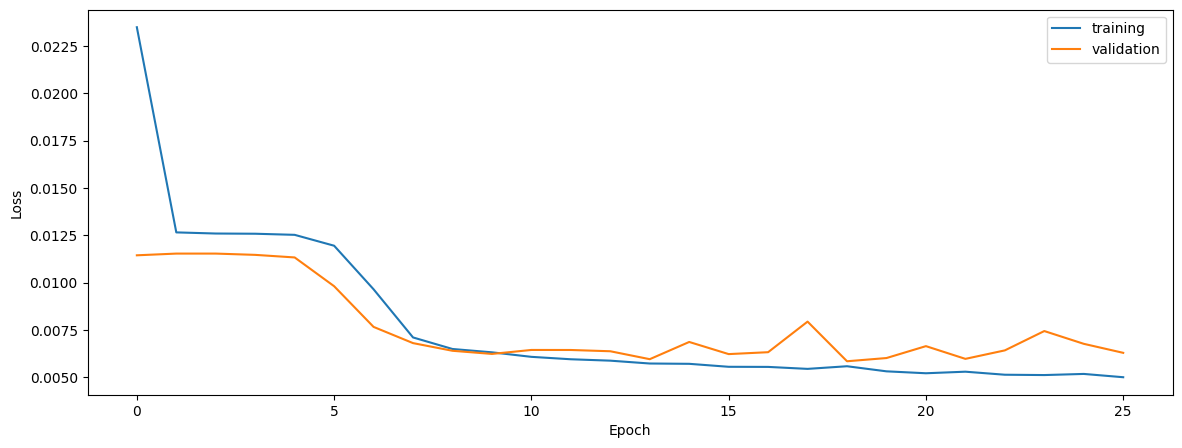

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7621642277306566
0.7046810993935672
0.715150812476584


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7621642277306566
0.7046810993935672
0.715150812476584


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7647462009986128
0.7165748379609462
0.7074779195304796


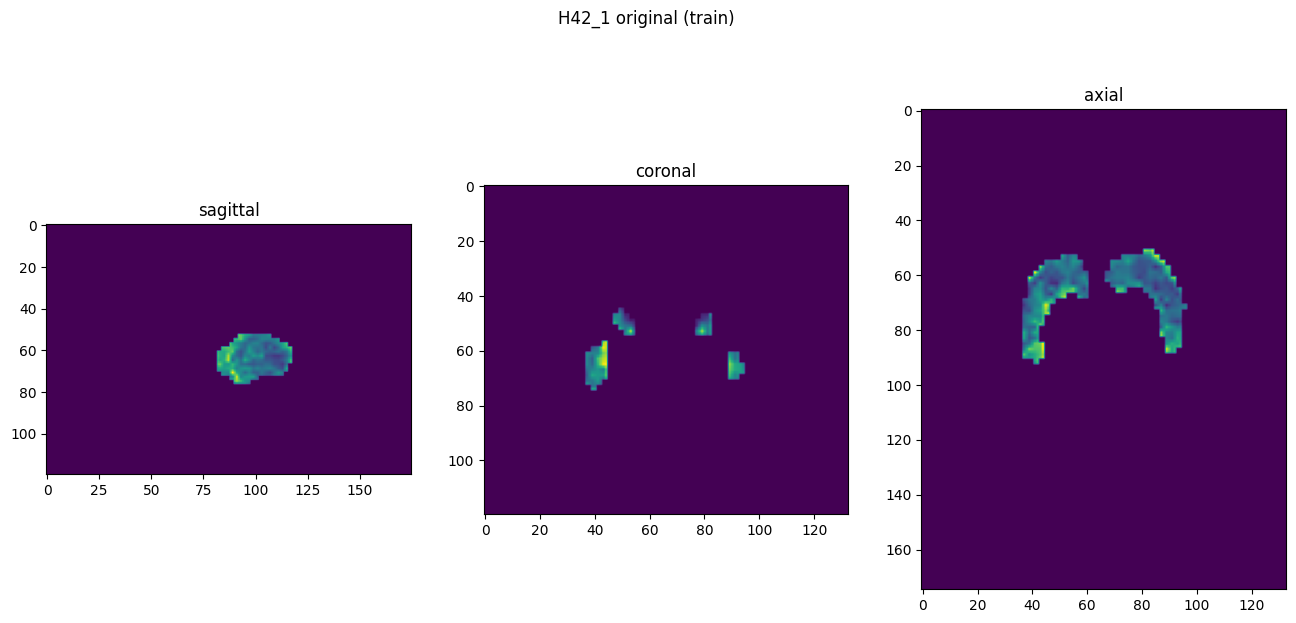

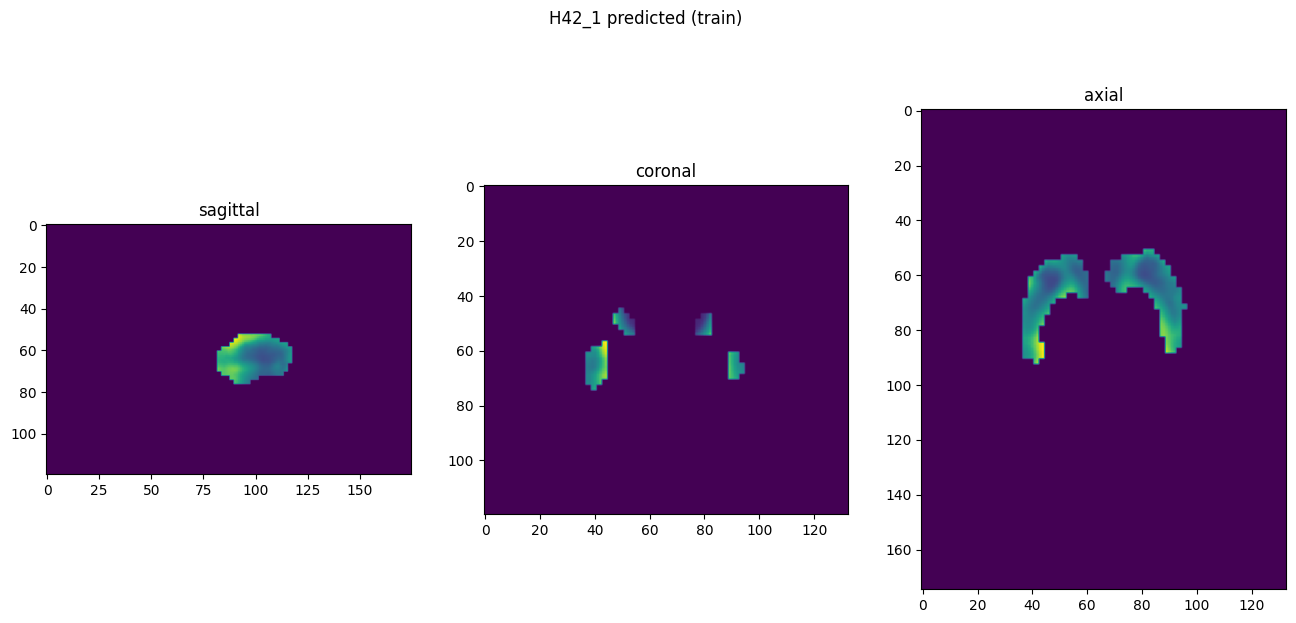

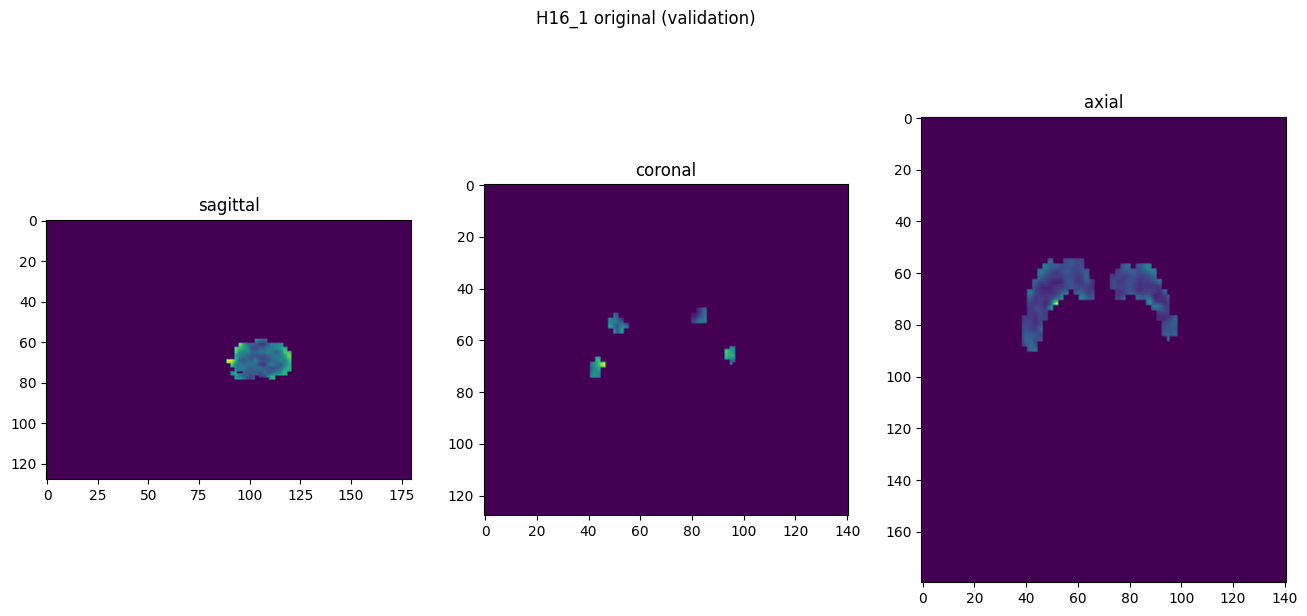

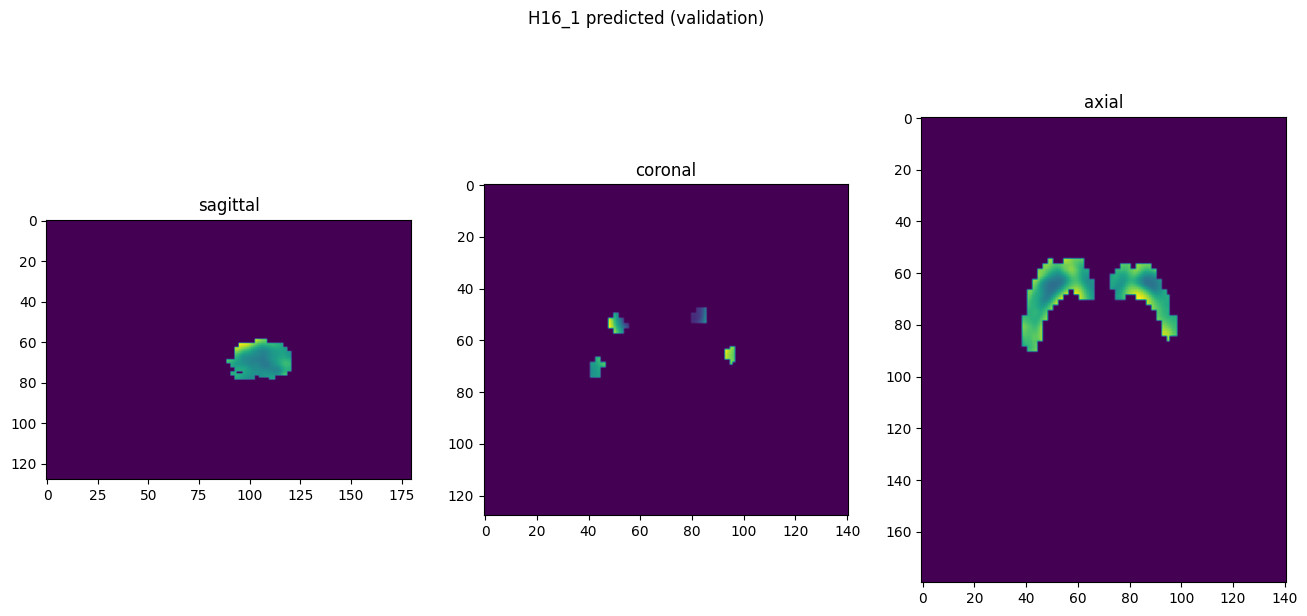

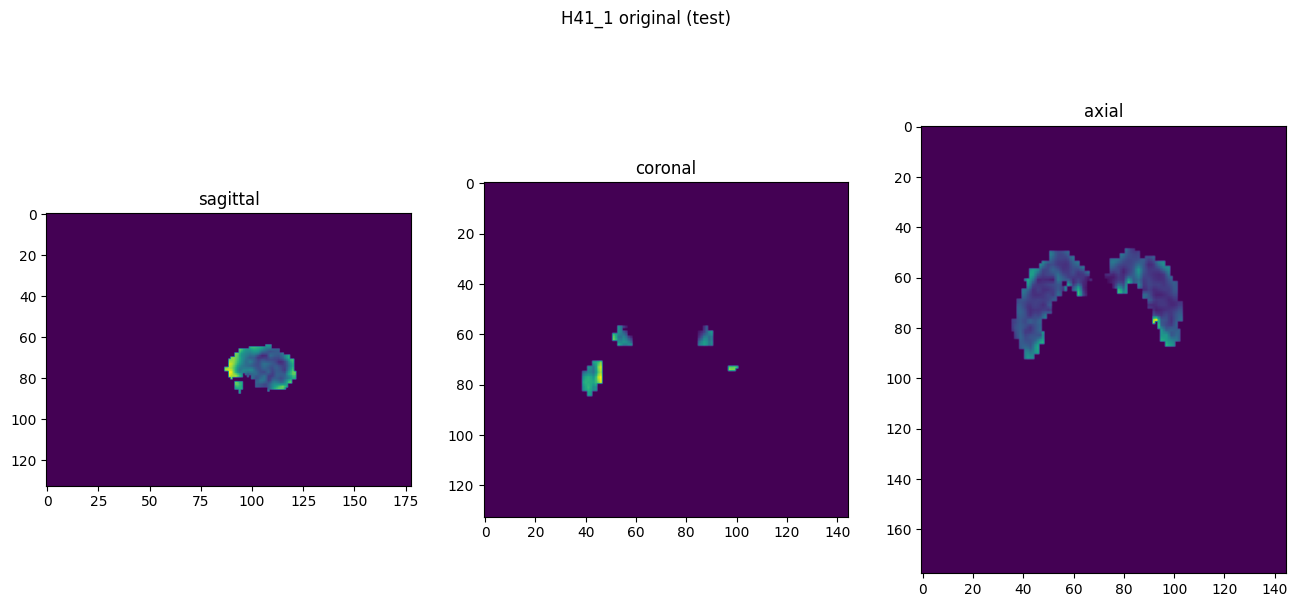

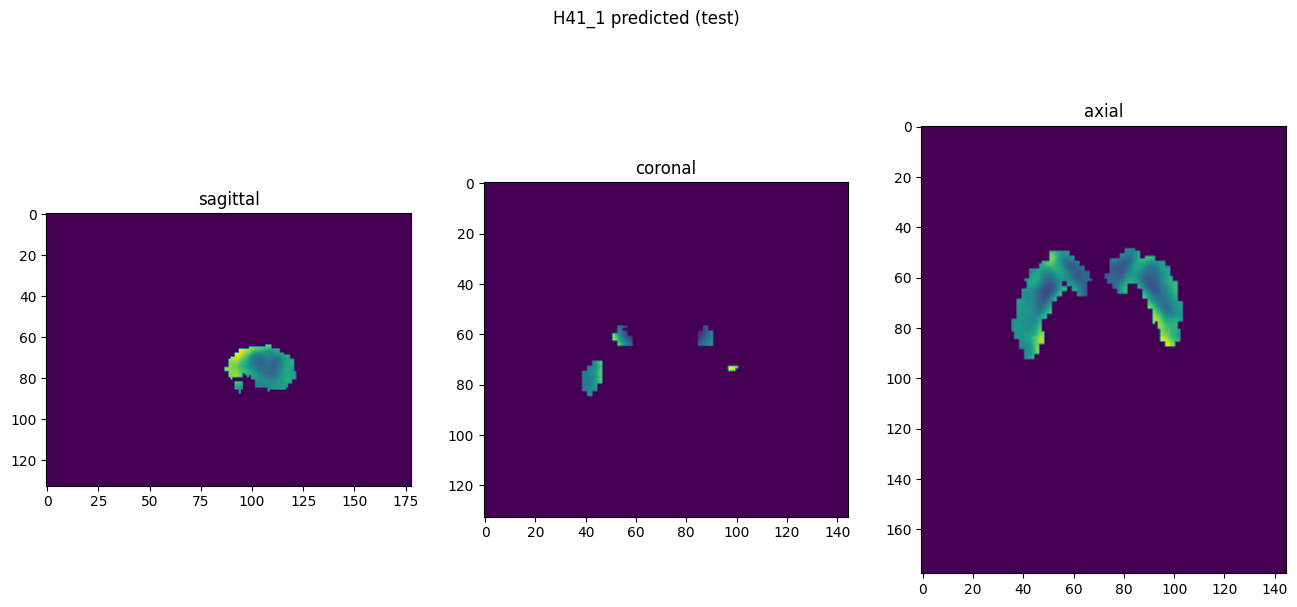

In [10]:
showResults(model, gen, threshold=None, background=False)